# Exercise 9.10

The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. <br> 
- [X] Load the dataset using the sklearn.datasets.fetch_olivetti_faces() function. 
- [X] Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set. 
- [X] Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter). 
- [X] Visualize the clusters: do you see similar faces in each cluster?

## Load data

In [1]:
from sklearn.datasets import fetch_olivetti_faces
fof = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [2]:
print(fof["DESCR"])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [3]:
data = fof["data"]

print("Size of data:", len(data))
print("Size of instances:", len(data[0]))

Size of data: 400
Size of instances: 4096


Let's take a look at the images themselves:

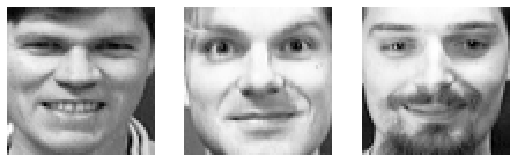

In [4]:
from numpy import random
import matplotlib.pyplot as plt

def see_faces(img_dataset, num_faces=3):
  # Reshape 4096 image to 64x64 data
  imgs_idx = random.randint(len(img_dataset), size=num_faces)
  imgs = [img.reshape(64,64) for img in img_dataset[imgs_idx]]

  # Plot image
  import matplotlib
  fig, axs = plt.subplots(1, num_faces, figsize=(9, num_faces), sharey=True)
  for img, i in zip(imgs, range(0,num_faces)):
    axs[i].imshow(img, cmap='Greys_r', interpolation="nearest")
    axs[i].axis("off")

see_faces(data)

## Split dataset into training set, validation set, and test set

In [5]:
X = data
y = fof["target"]

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits = 1, test_size=40)
train_val_idx, test_idx = next(sss.split(X, y))
X_train_val = X[train_val_idx]
y_train_val = y[train_val_idx]
X_test = X[test_idx]
y_test = y[test_idx]

sss = StratifiedShuffleSplit(n_splits=1, test_size=80)
train_idx, val_idx = next(sss.split(X_train_val, y_train_val))
X_train = X_train_val[train_idx]
y_train = y_train_val[train_idx]
X_val = X_train_val[val_idx]
y_val = y_train_val[val_idx]

In [7]:
len(X_train)+len(X_val)+len(X_test)==400

True

## Clustering

In [8]:
from sklearn.cluster import KMeans

Method chosen to find the number of clusters: The elbow technique using SSE (inertia).

In [9]:
from numpy import arange
sse = {}
for k in arange(5, 150, 5):
  kmeans = KMeans(n_clusters=k, max_iter=100).fit(X_train)
  sse[k]=kmeans.inertia_

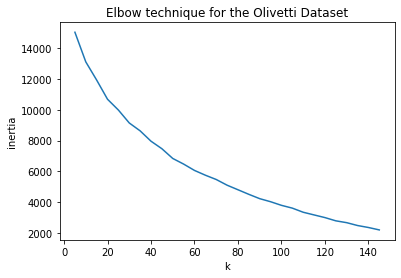

In [10]:
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("k")
plt.ylabel("inertia")
plt.title("Elbow technique for the Olivetti Dataset")
plt.show()

This technique wasn't enough to determine k. Let's use alternate methods.

Let's try the silhouette score.

In [11]:
from sklearn.metrics import silhouette_score

ss = {}
for k in arange(5, 150, 5):
  kmeans = KMeans(n_clusters=k, max_iter=100).fit(X_train)
  ss[k]=silhouette_score(X_train, kmeans.labels_)

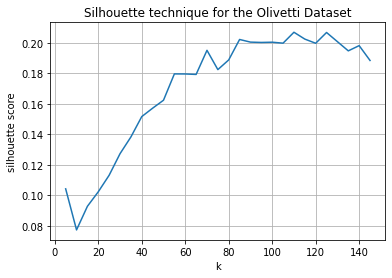

In [12]:
plt.plot(list(ss.keys()), list(ss.values()))
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.title("Silhouette technique for the Olivetti Dataset")
plt.grid()
plt.show()

K chosen: 120

In [13]:
# Train model
kmeans = KMeans(n_clusters=120, max_iter=100).fit(X_train)

## Visualize the clusters

Number of faces in this cluster: 3


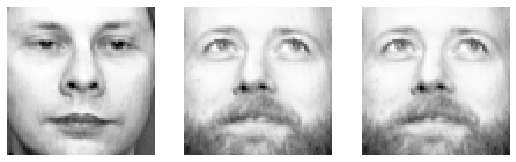

In [23]:
cluster_id = random.randint(120)
in_cluster = kmeans.labels_==cluster_id
assert sum(in_cluster)>1, "Number of faces should be greater than 1."
print("Number of faces in this cluster:", sum(in_cluster))
faces = X_train[in_cluster]
see_faces(faces, sum(in_cluster))

Even though some faces appears to be from the same person, the number k chosen shows that the model is clustering much more groups than it should. A broader look at the cluster will also show that many faces are uncorrectly assigned in clusters they (obviously, for a human) don't belong.

# Exercise 9.11

Continuing with the Olivetti faces dataset, 
- [X] Train a classifier to predict which person is represented in each picture, and evaluate it on the validation set. 
- [ ] Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set. Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach? 
- [ ] What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?

## Train classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=120)
rfc.fit(X_train, y_train)
rfc.score(X_val, y_val)

0.8875

The raw classifier appears to be much more accurate than the clutering model, even though it's much more simple.

## Use K-Means as dimensionality reduction method

In [16]:
X_train_red = kmeans.transform(X_train)
X_val_red = kmeans.transform(X_val)
X_test_red = kmeans.transform(X_test)

In [17]:
rfc = RandomForestClassifier(n_estimators=120)
rfc.fit(X_train_red, y_train)
rfc.score(X_val_red, y_val)

0.7625

In [18]:
from sklearn.pipeline import Pipeline
import tqdm

perf_dict = {}
k_list = arange(10,150,5)
for k, t in zip(k_list, tqdm.tqdm(range(len(k_list)))):
  pipeline = Pipeline([
                       ("kmeans", KMeans(n_clusters=k)),
                        ("rfc", RandomForestClassifier(n_estimators=120))
  ])
  pipeline.fit(X_train, y_train)
  perf_dict[k] = pipeline.score(X_val, y_val)

 96%|█████████▋| 27/28 [03:28<00:07,  7.73s/it]


In [19]:
print("Best K:", max(perf_dict, key=perf_dict.get))
print("Best score:", perf_dict[max(perf_dict, key=perf_dict.get)])

Best K: 85
Best score: 0.825


Stil isn't better than using raw classifier...

## Append reduced dataset as a feature to original dataset

In [20]:
from numpy import c_
X_train_ext = c_[X_train, X_train_red]
X_val_ext = c_[X_val, X_val_red]
X_test_ext = c_[X_test, X_test_red]

In [21]:
rfc = RandomForestClassifier(n_estimators=120)
rfc.fit(X_train_ext, y_train)
rfc.score(X_val_ext, y_val)

0.8625

## Conclusion

The K-Means algorithm didn't work well either in clustering the faces correctly (many people who do not look alike were clustered together), neither in reducing the dimensionality to help another algorithm to do it's job. \\
The K-Means algorithm could be useful here maybe to label new instances of data. With enough faces, the algorithm could be taught to recognize the label and then automatically labeling new data as it arives. Even so, some errors would be made. \\
Another algorithm shall be used to cluter/classify the faces in the images in the next exercises.